In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchmetrics import F1Score,ConfusionMatrix,ROC,PrecisionRecallCurve
from sklearn.metrics import ConfusionMatrixDisplay
import copy
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

#### Hyper params 

In [28]:
# Hyperparameters
n_epochs = 120
batch_size_train = 8
batch_size_test = 8
learning_rate = 1e-5
momentum = 0.5
decay_gamma = 0.0
label_smoothing = 0.01
weight_decay = 0.2
architecture = 'resnet152'
optimizer = 'Adam'#'Adam'#'SGD'
loss = 'FocalLoss'#'CrossEntropy'#'FocalLoss'
sigma = 0.0 # For gaussian noise added.

#For focal loss
gamma = 1.5
alpha = 0.5

#Use synthetic data?
syn_type = 'Poisson'#'Gaussian' #Poisson
synthetic_data = False

loss_weights = torch.tensor([1, 1])

In [37]:
converters = {
    'Label': lambda x: ast.literal_eval(x),
    'MaskDir': lambda x: ast.literal_eval(x) if str(x) != 'nan' else x
}
root_dir = '/Users/madsandersen/PycharmProjects/BscProjektData/'

# Load the DataSet.csv file
train_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/Train.csv', converters=converters)
val_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/Val.csv', converters=converters)

if synthetic_data:
    
    if syn_type != 'Mixed':
        synthetic_set = pd.read_csv(f'/work3/s204137/Mixed/{syn_type}/SyntheticData.csv')
    
    elif syn_type == 'Mixed':
        syn_gauss = pd.read_csv(f'/work3/s204137/Mixed/Gaussian/SyntheticData.csv')
        syn_pois = pd.read_csv(f'/work3/s204137/Mixed/Poisson/SyntheticData.csv')
        synthetic_set = pd.concat([syn_gauss, syn_pois])

l = len(synthetic_set) if synthetic_data else len(train_set)

In [38]:
# Downsample to class balance
# Select the non-faulty samples
non_faulty_samples = train_set[train_set['is_fault'] == False]

# Randomly select 1000 non-faulty samples
random_non_faulty_samples = non_faulty_samples.sample(n=350)

In [39]:
faulty_samples = train_set[train_set['is_fault'] == True]

In [40]:
train_set = pd.concat([faulty_samples, random_non_faulty_samples])

In [42]:
len(train_set)

656

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SolarELData(Dataset):

    def __init__(self, DataFrame, transform=None):
        self.data_set = DataFrame
        self.transform = transform
        #self.root = 'BachelorProject/Data/'
        self.root = '/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data'

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        img_name = self.data_set['ImageDir'].iloc[idx]
        img_name = f'{self.root}/{img_name}'
        image = Image.open(img_name)
        image = transforms.ToTensor()(image)

        # Resize the image to 224x224
        image = transforms.Resize((320, 320))(image)
        #pad the image
        #image = self.pad_image(image)

        # Make three channels
        image = torch.cat((image, image, image), 0)

        label = self.data_set['Label'].iloc[idx]
        label = self.one_hot_encode(label)

        if self.transform is not None:
            image = self.transform(image)

        #sample = {'image': image, 'label': label}
        #return sample
        return image,label

    def pad_image(self,image):
        max_widt, max_height = 430, 430
        width, height = image.shape[1], image.shape[2]
        pad_widt, pad_height = max_widt - width, max_height - height
        image = transforms.Pad((0, 0, pad_widt, pad_height))(image)
        return image

    def one_hot_encode(self, label):
        # One hot encoding
        place_holder = torch.tensor([0, 0], dtype=torch.float32)

        if 'Negative' in label:
            place_holder[0] = 1
        else:
            place_holder[1] = 1

        return place_holder

In [44]:
train_class = SolarELData(train_set)
val_class = SolarELData(val_set)

In [45]:
train_class[0]

(tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.1149, 0.0970, 0.0863],
          [0.0588, 0.0621, 0.0624,  ..., 0.1185, 0.0786, 0.0613],
          [0.0622, 0.0780, 0.0708,  ..., 0.1298, 0.0935, 0.0755],
          ...,
          [0.1255, 0.1163, 0.1155,  ..., 0.1624, 0.1351, 0.1248],
          [0.1251, 0.1264, 0.1271,  ..., 0.2083, 0.1275, 0.0987],
          [0.1216, 0.1359, 0.1440,  ..., 0.1878, 0.1346, 0.1059]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.1149, 0.0970, 0.0863],
          [0.0588, 0.0621, 0.0624,  ..., 0.1185, 0.0786, 0.0613],
          [0.0622, 0.0780, 0.0708,  ..., 0.1298, 0.0935, 0.0755],
          ...,
          [0.1255, 0.1163, 0.1155,  ..., 0.1624, 0.1351, 0.1248],
          [0.1251, 0.1264, 0.1271,  ..., 0.2083, 0.1275, 0.0987],
          [0.1216, 0.1359, 0.1440,  ..., 0.1878, 0.1346, 0.1059]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.1149, 0.0970, 0.0863],
          [0.0588, 0.0621, 0.0624,  ..., 0.1185, 0.0786, 0.0613],
          [0.0622, 0.0780, 0.0708,  ...,

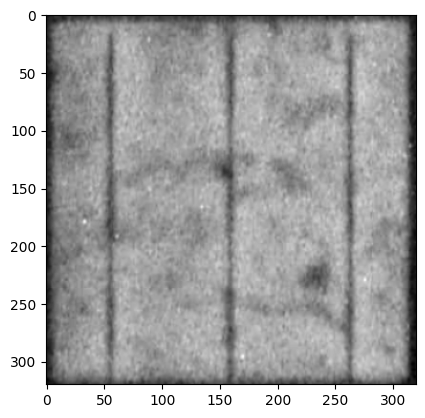

In [46]:
plt.imshow(val_class[22][0].numpy()[0,:,:],cmap= 'gray')

In [47]:
train_class[0][0].numpy()[0,:,:].shape

(320, 320)

In [48]:
train_class[1][0].numpy()[0,:,:].shape

(320, 320)

In [49]:
train_loader = DataLoader(train_class, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_class, batch_size=batch_size_test, shuffle=True)

In [50]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Define the max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.2)
        
        # Define the fully connected (linear) layers
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        
    def forward(self, x):
        # Pass the input tensor through the convolutional layers
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the output tensor
        x = x.view(-1, 128 * 4 * 4)
        
        # Pass the flattened tensor through the fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [51]:
#model = SmallCNN()
model = models.mobilenet_v2(weights = None)
# Modify the first layer to accept input of size 320x320x3
model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the last layer to output a tensor of shape (batch_size, 2)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)

In [52]:
criterion = nn.BCEWithLogitsLoss(weight=loss_weights.to(device), reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [53]:
def plot_conf_mat(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=Matrix.cpu().detach().numpy(),
                                      display_labels=['Negative', 'Positive'])
    disp.plot()

In [54]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [63]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions,labels = [],[]
    c = 0
    with torch.no_grad():
        for X, y in dataloader:
            
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predictions.append(F.softmax(pred,dim = 1))
            labels.append(y)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.5)).to(device)
    predictions = torch.vstack(predictions)
    labels = torch.vstack(labels)
    #print(labels)
    #print(predictions)
    cm = confmat(predictions[:,1],labels[:,1])
    
    print(cm)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.658895  [    8/  656]
loss: 0.671683  [  328/  656]
loss: 0.691735  [  648/  656]
tensor([[6900,  209],
        [  98,    4]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 562.565161 

Epoch 2
-------------------------------
loss: 0.628325  [    8/  656]
loss: 0.646815  [  328/  656]
loss: 0.668129  [  648/  656]
tensor([[6750,  359],
        [  97,    5]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 558.884937 

Epoch 3
-------------------------------
loss: 0.697158  [    8/  656]
loss: 0.689379  [  328/  656]
loss: 0.680282  [  648/  656]
tensor([[6833,  276],
        [  99,    3]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 549.835581 

Epoch 4
-------------------------------
loss: 0.727977  [    8/  656]
loss: 0.646735  [  328/  656]
loss: 0.645730  [  648/  656]
tensor([[6526,  583],
        [  89,   13]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 554.216773 

Epoch 5
-------------------------------
loss: 0.768351  [    8/  656]
loss: 0.644566  [ 

In [67]:
model.eval()
test_loss, correct = 0, 0
predictions,labels = [],[]
c = 0
with torch.no_grad():
    for X, y in val_loader:
        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predictions.append(F.softmax(pred,dim = 1))
        labels.append(y)
        test_loss += criterion(pred, y).item()
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.5)).to(device)
predictions = torch.vstack(predictions)
labels = torch.vstack(labels)

In [68]:
predictions

tensor([[0.5803, 0.4197],
        [0.5625, 0.4375],
        [0.5733, 0.4267],
        ...,
        [0.5784, 0.4216],
        [0.5784, 0.4216],
        [0.6039, 0.3961]])

In [69]:
def find_optimal_threshold(precisions, recalls, thresholds):
    """
    Given a list of precisions, recalls, and corresponding thresholds, finds the optimal threshold
    that maximizes the F1 score (harmonic mean of precision and recall).

    Args:
    - precisions (list): A list of precisions.
    - recalls (list): A list of recalls.
    - thresholds (list): A list of thresholds corresponding to the precisions and recalls.

    Returns:
    - The optimal threshold (float).
    """

    # Calculate F1 scores for each threshold
    f1_scores = [2 * (p * r) / (p + r) if p + r > 0 else 0 for p, r in zip(precisions, recalls)]

    # Find the index of the threshold with the highest F1 score
    max_index = f1_scores.index(max(f1_scores))

    # Return the corresponding threshold
    return thresholds[max_index],f1_scores[max_index]

In [78]:
precision, recall, thresholds= precision_recall_curve(labels[:,1].to(int),predictions[:,1])

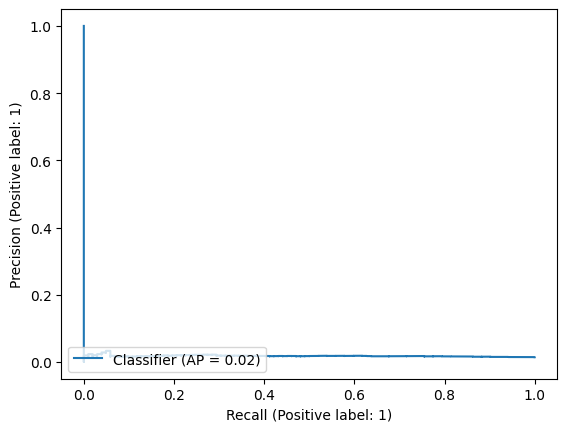

In [81]:
PrecisionRecallDisplay.from_predictions(labels[:,1].to(int),predictions[:,1])

In [84]:
find_optimal_threshold(precision, recall, thresholds)

(0.49898222, 0.04225352112676056)

In [86]:
confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.49898222)).to(device)
confmat(predictions[:,1],labels[:,1].to(int))

tensor([[6933,  176],
        [  97,    5]])

In [88]:
test_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/Test.csv', converters=converters)
test_class = SolarELData(test_set)
test_loader = DataLoader(test_class, batch_size=batch_size_test, shuffle=True)

In [90]:
test(test_loader, model, criterion)

tensor([[6878,  230],
        [  97,    5]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 565.973984 



- Mindre og større modeller 
- Infør syntetisk data, til non-DL
- Se om syntetisk data gør nogen forskel. Prøv evt. at lave et lille syntetisk test-set for at se om modellerne overfitter på artefakter.  
-